# Best Model, Tfidf + LogReg

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('../data/cleaned_engineered.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
# set X and y
X = df['title_selftext']
y = df['topics']
#baseline
y.value_counts(normalize=True)

0    0.500119
1    0.499881
Name: topics, dtype: float64

In [4]:
# train_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
pipe = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [6]:
params = {
     'tfid__stop_words': [None, 'english'],
     'tfid__min_df': [1,2,3,4],
     'tfid__max_df': [1.0, .75, .5, .25],
     'tfid__binary': [True, False],
#     'vect__max_features': [None, 4000, 5000],
     'tfid__ngram_range': [(1,2)]
#    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none']
}

gs = GridSearchCV(pipe,
                  param_grid=params,
                  verbose=1)
gs.fit(X_train, y_train)
print(gs.best_score_) # <- cross val score FTW
gs.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
0.9314088878794762


{'tfid__binary': False,
 'tfid__max_df': 1.0,
 'tfid__min_df': 2,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': 'english'}

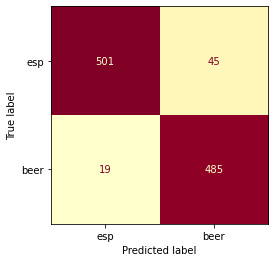

In [7]:
plot_confusion_matrix(gs, X_test, y_test, display_labels=['esp', 'beer'], cmap='YlOrRd', colorbar=False);

 - 501 true positive (correct espresso)
 - 45 false positive (incorrect espresso)
 - 19 false negative (incorrect beer)
 - 485 true negative (correct beer)

In [8]:
pred = gs.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       546
           1       0.92      0.96      0.94       504

    accuracy                           0.94      1050
   macro avg       0.94      0.94      0.94      1050
weighted avg       0.94      0.94      0.94      1050



In [9]:
preds_df = pd.DataFrame({
    'title_text' : X_test, 
    'actual' : y_test, 
    'predicted' : gs.predict(X_test),
    'P(r/espresso)' : [i[0] for i in gs.predict_proba(X_test)],
    'P(r/CraftBeer)' : [i[1] for i in gs.predict_proba(X_test)]})
preds_df['Prob Diff'] = np.abs(preds_df['P(r/CraftBeer)'] - preds_df['P(r/espresso)'])

In [10]:
#preds_df.to_csv('../data/best_preds.csv')